In [1]:
##########################################
#
#  Colab Check and test.
#

import sys as sys
import os  as os

print(str(get_ipython()))

if 'google.colab' in str(get_ipython()):
    
    print('Running on CoLab Installing Needed Packages')
    # installing unix libraries
    !apt-get -qq install libproj-dev libgeos-dev libnetcdf-dev libgrib-api-dev

    # cleaning up python libaries(shapely, imaug)
    !pip uninstall shapely imgaug --yes    
    !pip install imgaug==0.2.5
    !pip install --no-binary shapely shapely --force  

    # installing other python libraries
    !pip install cartopy ecCodes
    !pip install metpy netCDF4 h5py pydap wrf-python xarray cfgrib bottleneck pydap


    # install repaired version information tool (Python 3.8 and higher)
    !pip install git+https://github.com/wjcapehart/version_information

    print("")
    print("Colaboratory Libraries Installed")

#
##########################################################

In [3]:
import numpy                as np


import matplotlib.pyplot    as plt


import wrf                  as wrf 
import cfgrib               as cfg

import cartopy.crs          as ccrs
import cartopy.feature      as cfeature
import cartopy.io.img_tiles as cimgt
import cartopy.mpl          as cmpl

# import pyproj               as proj

In [4]:


# Enter Expected Values from your Namelist Files

parent_grid_ratio = [1,     3,    3]

i_parent_start    = [1,    44,   40]
j_parent_start    = [1,    51,   30]



e_we              = [150,   190,  169]
e_sn              = [150,   148,  190]

dx                = 9000.
dy                = 9000.


map_proj          = 'lambert'


ref_lat           = 44.47
ref_lon           = -102.75



truelat1          = 44.47
truelat2          = 44.47

stand_lon         = -102.75


projdict     = {'lambert': 1, 'polar': 2, 'mercator': 3, 'lat-lon': 6}
map_proj     = projdict[map_proj]
moad_cen_lat = np.average([truelat1,truelat2])




if (ref_lat >=0):
    pole_lat = 90
else:
    pole_lat = -90.

n_domains         = len(e_we)

dx_arr            = np.empty(n_domains)
dy_arr            = np.empty(n_domains)

dx_arr[0] = dx
dy_arr[0] = dy

for i in range(1,n_domains):
    dx_arr[i] = dx_arr[i-1] / parent_grid_ratio[i]
    dy_arr[i] = dy_arr[i-1] / parent_grid_ratio[i]


## Get Projection Generic Parameters 


# Package as a WRFProj Object

if   (map_proj == 1):
     wrf_projection_data = wrf.LambertConformal(TRUELAT1     =  truelat1,
                                                TRUELAT2     =  truelat2,
                                                MOAD_CEN_LAT = moad_cen_lat,
                                                STAND_LON    =    stand_lon,
                                                POLE_LAT     =     pole_lat,
                                                POLE_LON     =          0.0)
        
elif (map_proj == 2):
    wrf_projection_data = wrf.PolarStereographic(TRUELAT1     =     truelat1,
                                                 TRUELAT2     =     truelat2,
                                                 MOAD_CEN_LAT = moad_cen_lat,
                                                 STAND_LON    =    stand_lon,
                                                 POLE_LAT     =     pole_lat,
                                                 POLE_LON     =          0.0)


elif (map_proj == 3):
    wrf_projection_data = wrf.Mercator(TRUELAT1     =     truelat1,
                                       TRUELAT2     =     truelat2,
                                       MOAD_CEN_LAT = moad_cen_lat,
                                       STAND_LON    =    stand_lon,
                                       POLE_LAT     =     pole_lat,
                                       POLE_LON     =          0.0)
else:
    wrf_projection_data = wrf.LatLon(TRUELAT1     =     truelat1,
                                     TRUELAT2     =     truelat2,
                                     MOAD_CEN_LAT = moad_cen_lat,
                                     STAND_LON    =    stand_lon,
                                     POLE_LAT     =     pole_lat,
                                     POLE_LON     =          0.0)

    
wrf_projection_data = wrf.LambertConformal(TRUELAT1     =     truelat1,
                                           TRUELAT2     =     truelat2,
                                           MOAD_CEN_LAT = moad_cen_lat,
                                           STAND_LON    =    stand_lon,
                                           POLE_LAT     =     pole_lat,
                                           POLE_LON     =          0.0)


wrf_proj4 = wrf_projection_data.proj4()
wrf_crs   = wrf_projection_data.cartopy()




In [5]:
display('Proj4: %s' %wrf_proj4)
display(wrf_crs)

lonlat_crs = ccrs.PlateCarree()
display(lonlat_crs)

mercator_crs = ccrs.Mercator()
display(mercator_crs)



'Proj4: +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=44.47 +lat_2=44.47 +lat_0=44.47 +lon_0=-102.75 +nadgrids=@null'

In [6]:
# pull extents of each domain's arakawa grid

center_wrf = wrf_crs.transform_points(lonlat_crs,np.array(ref_lon),np.array(ref_lat))[0:1]



eastings_limits_ll_ur       = np.zeros([2,n_domains])
eastings_limits_ll_ur[:,0]  = center_wrf[0,0]+[- (e_we[0]-1)/2 * dx, (e_we[0]+1)/2 * dx]


northings_limits_ll_ur      = np.zeros([2,n_domains])
northings_limits_ll_ur[:,0] = center_wrf[0,1]+[- (e_sn[0]-1)/2 * dy, (e_sn[0]+1)/2 * dy]



print("------")
print("Domain ",(1), "Unstaggared Domain Corners")
print(lonlat_crs.transform_points(wrf_crs,
                 np.array([ eastings_limits_ll_ur[0,0],  eastings_limits_ll_ur[0,0],  eastings_limits_ll_ur[1,0],  eastings_limits_ll_ur[1,0]]),
                 np.array([northings_limits_ll_ur[0,0], northings_limits_ll_ur[1,0], northings_limits_ll_ur[1,0], northings_limits_ll_ur[0,0]])))

eastings_100_wrf  = np.empty([100,n_domains], dtype=np.float32)
northings_100_wrf = np.empty([100,n_domains], dtype=np.float32)

box_x_wrf         = np.empty([400,n_domains], dtype=np.float32)
box_y_wrf         = np.empty([400,n_domains], dtype=np.float32)  

eastings_100_wrf[:,0]  = np.linspace(eastings_limits_ll_ur[0,0],
                                     eastings_limits_ll_ur[1,0],
                                     100)

northings_100_wrf[:,0] = np.linspace(northings_limits_ll_ur[0,0],
                                     northings_limits_ll_ur[1,0],
                                     100) 

box_x_wrf[  0:100,0] = eastings_100_wrf[:,0]
box_x_wrf[100:200,0] = eastings_limits_ll_ur[1,0]
box_x_wrf[200:300,0] = np.flip(eastings_100_wrf[:,0])
box_x_wrf[300:400,0] = eastings_limits_ll_ur[0,0]


box_y_wrf[  0:100,0] = northings_limits_ll_ur[0,0]
box_y_wrf[100:200,0] = northings_100_wrf[:,0]
box_y_wrf[200:300,0] = northings_limits_ll_ur[1,0]
box_y_wrf[300:400,0] = np.flip(northings_100_wrf[:,0]) 



for i in range(1, n_domains):
    eastings_limits_ll_ur[0,i]  = eastings_limits_ll_ur[0,i-1]  + (i_parent_start[i]-1)*dx_arr[i-1]
    eastings_limits_ll_ur[1,i]  = eastings_limits_ll_ur[0,i]  + (e_we[i]-1.0)*dx_arr[i] 

    northings_limits_ll_ur[0,i] = northings_limits_ll_ur[0,i-1] + (j_parent_start[i]-1)*dy_arr[i-1]
    northings_limits_ll_ur[1,i] = northings_limits_ll_ur[0,i] + (e_sn[i]-1.0)*dy_arr[i] 
    
    eastings_100_wrf[:,i]  = np.linspace(eastings_limits_ll_ur[0,i],
                                         eastings_limits_ll_ur[1,i],
                                         100)
    
    northings_100_wrf[:,i] = np.linspace(northings_limits_ll_ur[0,i],
                                         northings_limits_ll_ur[1,i],
                                         100)    
    
    box_x_wrf[  0:100,i] = eastings_100_wrf[:,i]
    box_x_wrf[100:200,i] = eastings_limits_ll_ur[1,i]
    box_x_wrf[200:300,i] = np.flip(eastings_100_wrf[:,i])
    box_x_wrf[300:400,i] = eastings_limits_ll_ur[0,i]

    
    box_y_wrf[  0:100,i] = northings_limits_ll_ur[0,i]
    box_y_wrf[100:200,i] = northings_100_wrf[:,i]
    box_y_wrf[200:300,i] = northings_limits_ll_ur[1,i]
    box_y_wrf[300:400,i] = np.flip(northings_100_wrf[:,i]) 
    
    print("------")
    print("Domain ",(i+1), "Unstaggared Domain Corners")
    
    print(lonlat_crs.transform_points(wrf_crs,
                     np.array([ eastings_limits_ll_ur[0,i],  eastings_limits_ll_ur[0,i],  eastings_limits_ll_ur[1,i],  eastings_limits_ll_ur[1,i]]),
                     np.array([northings_limits_ll_ur[0,i], northings_limits_ll_ur[1,i], northings_limits_ll_ur[1,i], northings_limits_ll_ur[0,i]])))


    



# Reproject the WRF Box Points.  You need to cut off the "z" mapping coordinates
#   from the two

box_x_mercator =  mercator_crs.transform_points(wrf_crs,box_x_wrf,box_y_wrf)[:,:,0]
box_y_mercator =  mercator_crs.transform_points(wrf_crs,box_x_wrf,box_y_wrf)[:,:,1]


box_x_lonlat   =  lonlat_crs.transform_points(wrf_crs,box_x_wrf,box_y_wrf)[:,:,0]
box_y_lonlat   =  lonlat_crs.transform_points(wrf_crs,box_x_wrf,box_y_wrf)[:,:,1]
print(" ")



------
Domain  1 Unstaggared Domain Corners
[[-110.38741629   38.16972481    0.        ]
 [-112.14806946   50.2250148     0.        ]
 [ -93.2269116    50.21572057    0.        ]
 [ -95.01067491   38.16217073    0.        ]]
------
Domain  2 Unstaggared Domain Corners
[[-106.2038233    42.43326086    0.        ]
 [-106.4464878    46.39531617    0.        ]
 [ -99.0535122    46.39531617    0.        ]
 [ -99.2961767    42.43326086    0.        ]]
------
Domain  3 Unstaggared Domain Corners
[[-104.80587308   43.25048556    0.        ]
 [-104.86624333   44.94982019    0.        ]
 [-102.73093049   44.96919394    0.        ]
 [-102.73147472   43.2693031     0.        ]]
 


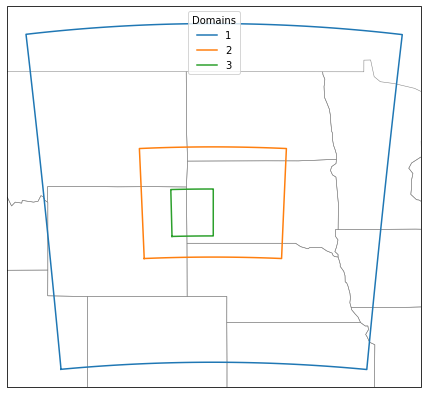

In [7]:
fig = plt.figure(figsize=(11, 7))

# add a plot element just one field aka the "Axes"

ax = fig.add_subplot(1,  # nrows
                     1,  # ncols 
                     1,  # index of figure you're installing
                     projection = mercator_crs) # cartopy CRS Projection


ax.plot(box_x_wrf[:,:],box_y_wrf[:,:], transform=wrf_crs)


ax.coastlines(linewidths =  0.75)

ax.add_feature(cfeature.STATES.with_scale('110m'), 
                   linewidths = 0.5,
                   facecolor  = 'none', 
                   edgecolor  = 'tab:gray')

plt.legend(np.linspace(1,n_domains,n_domains).astype("int"),
           title = "Domains")

plt.show()

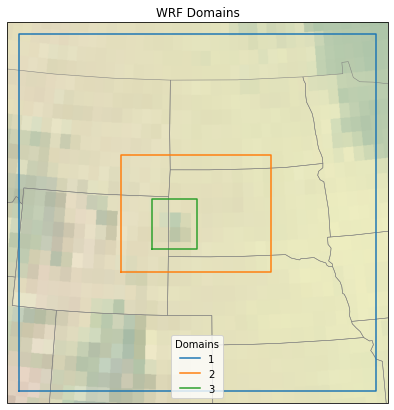

In [8]:
fig = plt.figure(figsize=(11, 7))

# add a plot element just one field aka the "Axes"

ax = fig.add_subplot(1,  # nrows
                     1,  # ncols 
                     1,  # index of figure you're installing
                     projection = wrf_crs) # cartopy CRS Projection

ax.set_xlim([(box_x_wrf[:,0].min() - 5*dx_arr[0]),
             (box_x_wrf[:,0].max() + 5*dx_arr[0])])

ax.set_ylim([(box_y_wrf[:,0].min() - 5*dy_arr[0]),
             (box_y_wrf[:,0].max() + 5*dy_arr[0])])



ax.coastlines(linewidths =  0.75)

ax.add_feature(cfeature.STATES.with_scale('110m'), 
                   linewidths = 0.5,
                   facecolor  = 'none', 
                   edgecolor  = 'tab:gray')

ax.stock_img()

plt.plot(box_x_wrf,
         box_y_wrf)

plt.legend(np.linspace(1,n_domains,n_domains).astype("int"),
           title = "Domains")

plt.title("WRF Domains")
plt.show()


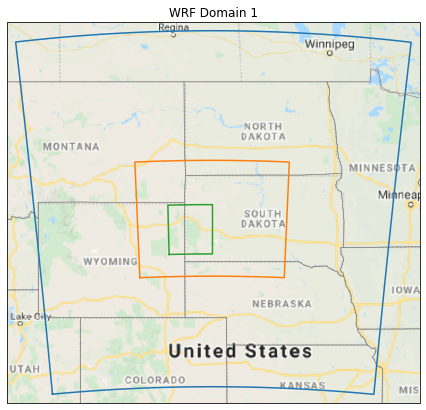

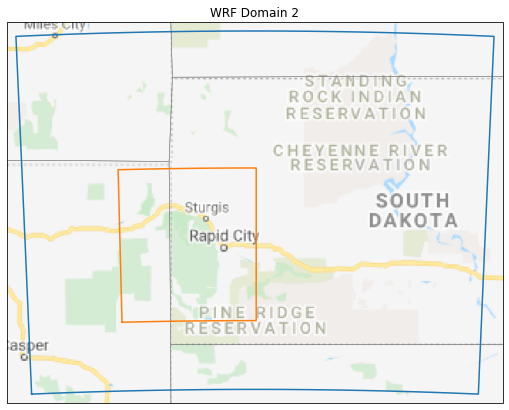

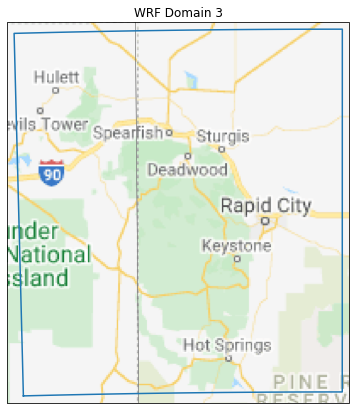

In [9]:


for i in range(0, n_domains) : 


    fig = plt.figure(figsize=(11, 7))
    
    

    

    # add a plot element just one field aka the "Axes"

    ax = fig.add_subplot(1,  # nrows
                         1,  # ncols 
                         1,  # index of figure you're installing
                         projection = mercator_crs) # cartopy CRS Projection

    ax.set_xlim([(box_x_mercator[:,i].min() - 5*dx_arr[i]),
                 (box_x_mercator[:,i].max() + 5*dx_arr[i])])
    
    ax.set_ylim([(box_y_mercator[:,i].min() - 5*dy_arr[i]),
                 (box_y_mercator[:,i].max() + 5*dy_arr[i])])

    ax.autoscale_view()
    
    tiler = cimgt.GoogleTiles()
    
    ax.add_image(tiler ,(i+8-3))

    ax.coastlines(linewidths =  0.75)

    ax.add_feature(cfeature.STATES.with_scale('110m'), 
                       linewidths = 0.5,
                       facecolor  = 'none', 
                       edgecolor  = 'tab:gray')


    
    plt.plot(box_x_wrf[:,i:], box_y_wrf[:,i:], transform=wrf_crs)


    
    plt.title("WRF Domain " + str(i+1))



    plt.show()

